In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '4*'

In [ ]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

 56% 27.0M/48.1M [00:00<00:00, 124MB/s] 
100% 48.1M/48.1M [00:00<00:00, 160MB/s]


In [ ]:
!unzip sign-language-for-numbers.zip

Streaming output truncated to the last 5000 lines.
  inflating: Sign Language for Numbers/7/seven_549.jpg  
  inflating: Sign Language for Numbers/7/seven_55.jpg  
  inflating: Sign Language for Numbers/7/seven_550.jpg  
  inflating: Sign Language for Numbers/7/seven_551.jpg  
  inflating: Sign Language for Numbers/7/seven_552.jpg  
  inflating: Sign Language for Numbers/7/seven_553.jpg  
  inflating: Sign Language for Numbers/7/seven_554.jpg  
  inflating: Sign Language for Numbers/7/seven_555.jpg  
  inflating: Sign Language for Numbers/7/seven_556.jpg  
  inflating: Sign Language for Numbers/7/seven_557.jpg  
  inflating: Sign Language for Numbers/7/seven_558.jpg  
  inflating: Sign Language for Numbers/7/seven_559.jpg  
  inflating: Sign Language for Numbers/7/seven_56.jpg  
  inflating: Sign Language for Numbers/7/seven_560.jpg  
  inflating: Sign Language for Numbers/7/seven_561.jpg  
  inflating: Sign Language for Numbers/7/seven_562.jpg  
  inflating: Sign Language for Numbers/

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [ ]:
data_directory = "/content/Sign Language for Numbers"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torchvision as torchvision
model = torchvision.models.resnet18(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(validation_loader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_loader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/181], Loss: 1.940144658088684
Epoch [1/10], Step [100/181], Loss: 1.638066291809082
Epoch [1/10], Step [150/181], Loss: 1.2897833585739136
Epoch [1/10], Training Loss: 1.620263134906305, Training Accuracy: 0.44805192947387695, Validation Loss: 3.8950511400516215, Validation Accuracy: 0.08484848588705063
Epoch [2/10], Step [50/181], Loss: 1.0459797382354736
Epoch [2/10], Step [100/181], Loss: 0.6023498177528381
Epoch [2/10], Step [150/181], Loss: 0.4838143289089203
Epoch [2/10], Training Loss: 0.7718259898009221, Training Accuracy: 0.7415584325790405, Validation Loss: 0.8330587612894865, Validation Accuracy: 0.7200000286102295
Epoch [3/10], Step [50/181], Loss: 0.48494940996170044
Epoch [3/10], Step [100/181], Loss: 0.4080222547054291
Epoch [3/10], Step [150/181], Loss: 0.22454047203063965
Epoch [3/10], Training Loss: 0.4295034424211439, Training Accuracy: 0.8541991114616394, Validation Loss: 1.1778303998020978, Validation Accuracy: 0.6000000238418579
Epoch [4/10]

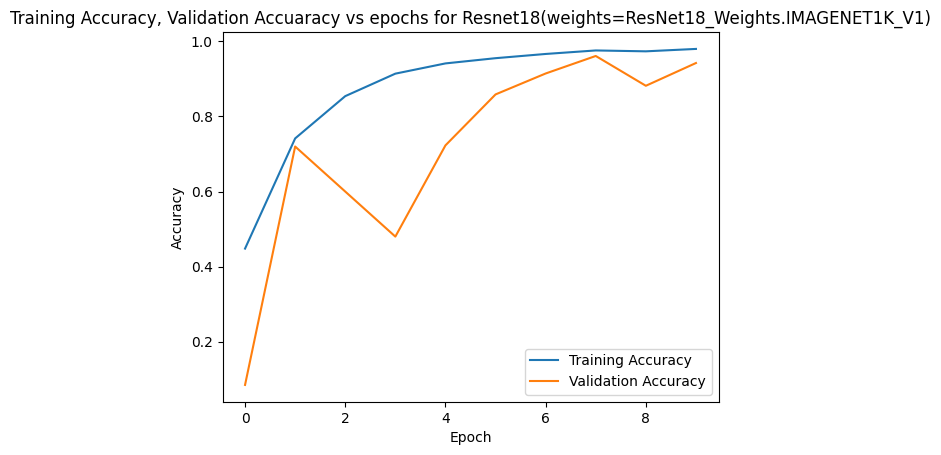

In [ ]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for Resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Test Accuracy: 0.9403030303030303


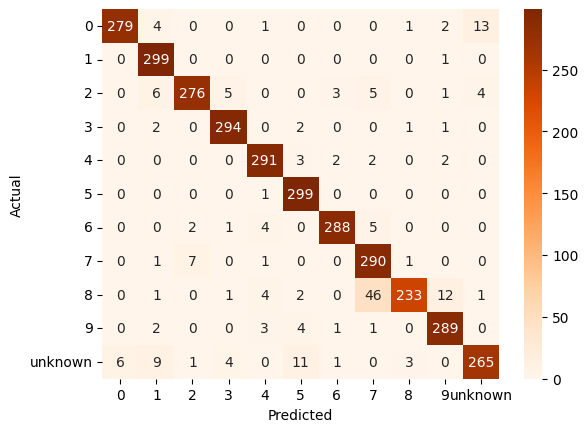

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       300
           1       0.92      1.00      0.96       300
           2       0.97      0.92      0.94       300
           3       0.96      0.98      0.97       300
           4       0.95      0.97      0.96       300
           5       0.93      1.00      0.96       300
           6       0.98      0.96      0.97       300
           7       0.83      0.97      0.89       300
           8       0.97      0.78      0.86       300
           9       0.94      0.96      0.95       300
     unknown       0.94      0.88      0.91       300

    accuracy                           0.94      3300
   macro avg       0.94      0.94      0.94      3300
weighted avg       0.94      0.94      0.94      3300



In [ ]:
model.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

target_names = list(train_dataset.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds, target_names=target_names))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.003s...
[t-SNE] Computed neighbors for 11550 samples in 6.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 2.000569
[t-SNE] KL divergence

<ipython-input-14-47d71a04a03e>:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', len(target_names)-1)
<ipython-input-14-47d71a04a03e>:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))


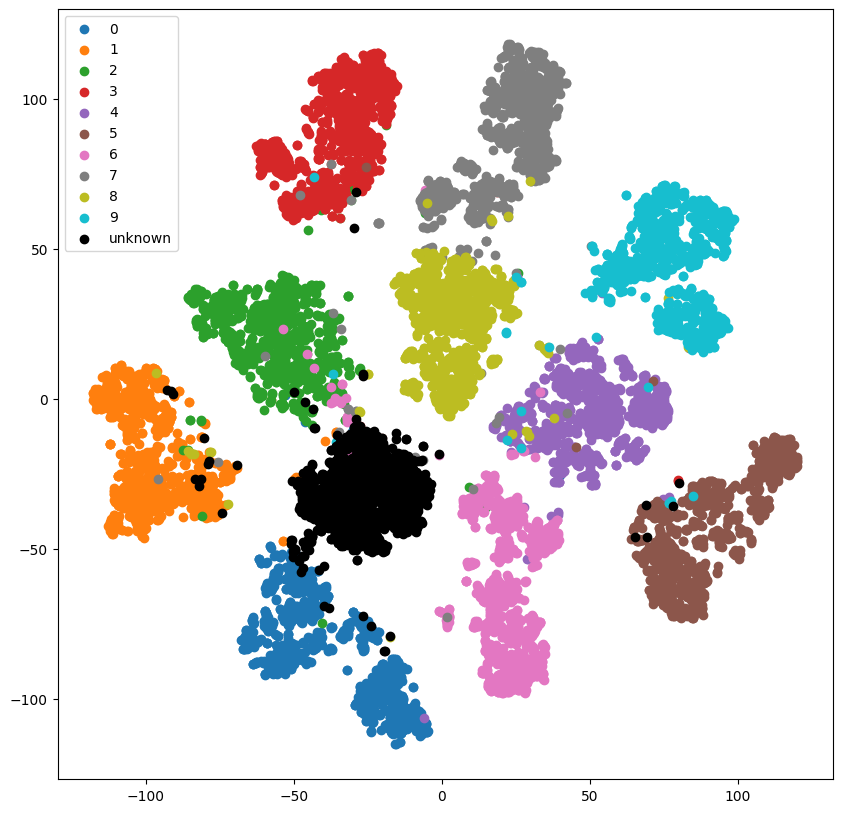

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


model.to('cuda')


model = torch.nn.Sequential(*(list(model.children())[:-1]))


model.eval()

features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)


u = labels == target_names.index("unknown")

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()


